In [119]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.
     
       Prints the result to stdout and returns the exit status. 
       Provides a printed warning on non-zero exit status unless `warn` 
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2020/project2.git .tmp
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

%%latex
\newcommand{\vect}[1]{\mathbf{#1}}
\newcommand{\cnt}[1]{\sharp(#1)}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\softmax}{\operatorname{softmax}}
\newcommand{\Prob}{\Pr}
\newcommand{\given}{\,|\,}

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Project 2: Sequence labeling – The slot filling task

The second segment of the project involves a sequence labeling task, in which the goal is to label the tokens in a text. Many NLP tasks have this general form. Most famously is the task of _part-of-speech labeling_ as you explored in lab 2-4, where the tokens in a text are to be labeled with their part of speech (noun, verb, preposition, etc.). In this project segment, however, you'll use sequence labeling to implement a system for filling the slots in a template that is intended to describe the meaning of an ATIS query. For instance, the sentence 

    What's the earliest arriving flight between Boston and Washington DC?
    
might be associated with the following slot-filled template: 

    flight_id
        fromloc.cityname: boston
        toloc.cityname: washington
        toloc.state: dc
        flight_mod: earliest arriving
    
You may wonder how this task is a sequence labeling task. We label each word in the source sentence with a tag taken from a set of tags that correspond to the slot-labels. For each slot-label, say `flight_mod`, there are two tags: `B-flight_mod` and `I-flight_mod`. These are used to mark the beginning (B) or interior (I) of a phrase that fills the given slot. In addition, there is a tag for other (O) words that are not used to fill any slot. (This technique is thus known as IOB encoding.) Thus the sample sentence would be labeled as follows:

| Token   | Label    |
| ------- | ------ | 
| BOS | O |
| what's | O |
| the | O |
| earliest | B-flight_mod |
| arriving | I-flight_mod |
| flight | O |
| between | O |
| boston | B-fromloc.city_name |
| and | O |
| washington | B-toloc.city_name |
| dc | B-toloc.state_code |
| EOS | O |

> See below for information about the `BOS` and `EOS` tokens. 

The template itself is associated with the question type for the sentence, perhaps as recovered from the sentence in the last project segment.

In this segment, you'll implement two methods for sequence labeling: a hidden Markov model (HMM) and two recurrent neural networks, a simple RNN and a long short-term memory network (LSTM). By the end of this homework, you should have grasped the pros and cons of both approaches.

## Goals

1. Implement an HMM-based approach to sequence labeling.
2. Implement an RNN-based approach to sequence labeling.
3. Implement an LSTM-based approach to sequence labeling.
4. (Optional) Compare the performances of HMM and RNN/LSTM under different amount of training data. Discuss the pros and cons of the HMM approach and the neural approach.

## Setup

In [120]:
import copy
import math
import matplotlib.pyplot as plt
import random
import warnings

import torch
import torch.nn as nn
import torchtext as tt

from tqdm import tqdm

# Set random seeds
seed = 1234
random.seed(seed)
torch.manual_seed(seed)

# GPU check, sets runtime type to "GPU" where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load Data

First, we download the ATIS dataset, already presplit into training, validation (dev), and test sets.

In [121]:
shell("""
  wget -nv -N -P data https://raw.githubusercontent.com/nlp-236299/data/master/ATIS/atis.train.txt
  wget -nv -N -P data https://raw.githubusercontent.com/nlp-236299/data/master/ATIS/atis.dev.txt
  wget -nv -N -P data https://raw.githubusercontent.com/nlp-236299/data/master/ATIS/atis.test.txt
""")

### Data preprocessing

We again use `torchtext` to load data and convert words to indices in the vocabulary. We use one field `TEXT` for processing the question, and another field `TAG` for processing the sequence labels.

We treat words occurring fewer than three times in the training data as _unknown words_. They'll be replaced by the unknown word type `<unk>`.

In [122]:
## Turn off annoying torchtext warnings about pending deprecations
warnings.filterwarnings("ignore", module="torchtext", category=UserWarning)

In [123]:
MIN_FREQ = 3

TEXT = tt.data.Field(init_token="<bos>")
TAG = tt.data.Field(init_token="<bos>")
fields=(('text', TEXT), ('tag', TAG))

train, val, test = tt.datasets.SequenceTaggingDataset.splits(
  fields=fields, 
  path='./data/', 
  train='atis.train.txt',
  validation='atis.dev.txt',
  test='atis.test.txt'
)

TEXT.build_vocab(train.text, min_freq=MIN_FREQ)
TAG.build_vocab(train.tag)

We can get some sense of the datasets by looking at the size and some elements of the text and tag vocabularies.

In [124]:
print(f"Size of English vocabulary: {len(TEXT.vocab)}")
print(f"Most common English words: {TEXT.vocab.freqs.most_common(10)}\n")

print(f"Number of tags: {len(TAG.vocab)}")
print(f"Most common tags: {TAG.vocab.freqs.most_common(10)}")

Size of English vocabulary: 518
Most common English words: [('BOS', 4274), ('EOS', 4274), ('to', 3682), ('from', 3203), ('flights', 2075), ('the', 1745), ('on', 1343), ('flight', 1035), ('me', 1005), ('what', 985)]

Number of tags: 104
Most common tags: [('O', 38967), ('B-toloc.city_name', 3751), ('B-fromloc.city_name', 3726), ('I-toloc.city_name', 1039), ('B-depart_date.day_name', 835), ('I-fromloc.city_name', 636), ('B-airline_name', 610), ('B-depart_time.period_of_day', 555), ('I-airline_name', 374), ('B-depart_date.day_number', 351)]


### Special tokens and tags

You'll have already noticed the `BOS` and `EOS`, special tokens that the dataset developers used to indicate the beginning and end of the sentence; we'll leave them in the data.

We've also passed in `init_token="<bos>"` for both torchtext fields. Torchtext will prepend these to the sequence of words and tags. This relieves us from estimating the initial distribution of tags and tokens in HMMs, since we always start with a token `<bos>` whose tag is also `<bos>`. We'll be able to refer to these tags as exemplified here:

In [125]:
print(f"""
Initial tag string: {TAG.init_token}
Initial tag id:     {TAG.vocab.stoi[TAG.init_token]}
""")


Initial tag string: <bos>
Initial tag id:     2



Finally, since torchtext will be providing the sentences in the training corpus in "batches", torchtext will force the sentences within a batch to be the same length by padding them with a special token. Again, we can access that token as shown here:

In [126]:
print(f"""
Pad tag string: {TAG.pad_token}
Pad tag id:     {TAG.vocab.stoi[TAG.pad_token]}
""")


Pad tag string: <pad>
Pad tag id:     1



Now, we can iterate over the dataset using `torchtext`'s iterator. We'll use a non-trivial batch size to gain the benefit of training on multiple sentences at a shot. This is different from how you've previously used torch, with a batch size of 1, and you'll need to be careful about the shapes of the various tensors that are being manipulated.

In [127]:
BATCH_SIZE = 20

train_iter, val_iter, test_iter = tt.data.BucketIterator.splits(
    (train, val, test), 
    batch_size=BATCH_SIZE, 
    repeat=False, 
    device=device)

Each batch will be a tensor of size `max_length x batch_size`. Let's examine a batch.

In [128]:
# Get the first batch
batch = next(iter(train_iter))

# What's its shape? Should be max_length x batch_size.
print(f'Shape of batch text tensor: {batch.text.shape}\n')

# Extract the first sentence in the batch, both text and tags
first_sentence = batch.text[:, 0]
first_tags = batch.tag[:, 0]

# Print out the first sentence, as token ids and as text
print("First sentence in batch")
print(f"{first_sentence}")
print(f"{' '.join([TEXT.vocab.itos[i] for i in first_sentence])}\n")

print("First tags in batch")
print(f"{first_tags}")
print(f"{[TAG.vocab.itos[i] for i in first_tags]}")

Shape of batch text tensor: torch.Size([22, 20])

First sentence in batch
tensor([ 2,  3, 21, 45, 88, 44,  7, 39, 28, 20, 54, 18, 22,  4,  1,  1,  1,  1,
         1,  1,  1,  1])
<bos> BOS i need information for flights leaving baltimore and arriving in atlanta EOS <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

First tags in batch
tensor([2, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1])
['<bos>', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'O', 'O', 'B-toloc.city_name', 'O', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


The goal of this project is to predict the sequence of tags `batch.tag` given a sequence of words `batch.text`.

## Majority class labeling

As usual, we can get a sense of the difficulty of the task by looking at a simple baseline, tagging every token with the majority tag. Here's a table of tag frequencies for the most frequent tags:

In [129]:
tag_counts = torch.zeros(len(TAG.vocab.itos), device=device)

for batch in train_iter:              # for each batch
  for sent_id in range(len(batch)):   # ... each sentence in the batch
    for tag in batch.tag[:, sent_id]: # ... each tag in the sentence
      tag_counts[tag] += 1            # bump the tag count

for tag_id in range(len(TAG.vocab.itos)):
  print(f'{tag_id:3}  {TAG.vocab.itos[tag_id]:30}{tag_counts[tag_id].item():3.0f}')

  0  <unk>                           0
  1  <pad>                         42094
  2  <bos>                         4274
  3  O                             38967
  4  B-toloc.city_name             3751
  5  B-fromloc.city_name           3726
  6  I-toloc.city_name             1039
  7  B-depart_date.day_name        835
  8  I-fromloc.city_name           636
  9  B-airline_name                610
 10  B-depart_time.period_of_day   555
 11  I-airline_name                374
 12  B-depart_date.day_number      351
 13  B-depart_date.month_name      340
 14  B-depart_time.time            321
 15  B-round_trip                  311
 16  I-round_trip                  303
 17  B-depart_time.time_relative   290
 18  B-cost_relative               281
 19  B-flight_mod                  264
 20  I-depart_time.time            258
 21  B-stoploc.city_name           202
 22  B-city_name                   191
 23  B-arrive_time.time            182
 24  B-class_type                  181
 25  B-arrive_tim

It looks like the `'O'` (other) tag is, unsurprisingly, the most frequent tag (except for the padding tag). The proportion of tokens labeled with that tag (ignoring the padding tag) gives us a good baseline accuracy for this sequence labeling task. If we were to just label every token with the `'O'` tag, we'd expect to be right on this proportion of the tokens.

In [130]:
majority_baseline_accuracy = (
  tag_counts[TAG.vocab.stoi['O']] 
  / (sum(tag_counts) 
     - tag_counts[TAG.vocab.stoi[TAG.pad_token]])
)
print(f'Baseline accuracy: {majority_baseline_accuracy:.3f}')

Baseline accuracy: 0.637


## HMM for sequence labeling

Having established the baseline to beat, we turn to implementing an HMM model.

### Notation

First, let's start with some notation. We use $Q = \langle{Q_1, Q_2, \ldots, Q_N} \rangle$ to denote the possible tags, which is the state space of the HMM, and $\mathcal{V} = \langle v_1, v_2, \ldots v_V \rangle$ to denote the vocabulary of word types.  We use $q_{t}\in Q$ to denote the state at time step $t$ (where $t$ varies from $1$ to $T$), and $o_t\in \mathcal{V}$ to denote the observation (word) at time step $t$.

### Training an HMM by counting

Recall that an HMM is defined via a transition matrix $A$ which stores the probability of moving from one state $Q_i$ to another $Q_j$, that is, 

$$A_{ij}=P(q_{t+1}=Q_j  \given  q_t=Q_i)$$

and an emission matrix $B$ which stores the probability of generating word $\mathcal{V}_j$ given state $Q_i$, that is, 

$$B_{ij}= P(o_t=\mathcal{V}_j  \given q_t= Q_i)$$

> As is typical in notating probabilities, we'll use abbreviations
>
\begin{align}
P(q_{t+1} \given  q_t) &\equiv P(q_{t+1}=Q_j  \given  q_t=Q_i) \\
P(o_t  \given q_t) &\equiv P(o_t=\mathcal{V}_j  \given q_t= Q_i)
\end{align}
>
> where the $i$ and $j$ are clear from context.

In our case, since the labels are observed in the training data, we can directly use counting to determine (maximum likelihood) estimates of $A$ and $B$.

#### Goal 1(a): Find the transition matrix

The matrix $A$ contains the transition probabilities: $A_{ij}$ is the probability of moving from state $Q_i$ to state $Q_j$ in the training data, so that $\sum^{N}_{j = 1 } A_{ij} = 1$ for all $i$. 

We find these probabilities by counting the number of times state $Q_j$ appears right after state $Q_i$, as a proportion of all of the transitions from $Q_i$.

$$
A_{ij} = \frac{\cnt{Q_i, Q_j} + \delta}{\cnt{Q_i} + \delta N}
$$

(In the above formula, we also used add-$\delta$ smoothing.)

Using the above definition, implement the method `train_A` in the `HMM` class, which calculates and returns the $A$ matrix as a tensor of size $N \times N$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

> Remember that the training data is being delivered to you batched.

#### Goal 1(b): Find the emission matrix $B$

Similar to the transition matrix, the emission matrix contains the emission probabilities such that $B_{ij}$ is probability of word $o_t=\mathcal{V}_j$ conditioned on state $q_t=Q_i$.

We can find this by counting as well.
$$
B_{ij} = \frac{\cnt{Q_i, \mathcal{V}_j} + \delta}{\cnt{Q_i} + \delta V}
$$

Using the above definitions, implement the `train_B` method in the `HMM` class, which calculates and returns the $B$ matrix as a tensor of size $N \times V$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

### Sequence labeling with a trained HMM

Now that you're able to train an HMM by estimating the transition matrix $A$ and the emission matrix $B$, you can apply it to the task of sequence labeling. Our goal is to find the most probable sequence of tags $\hat q \in Q^T$ given a sequence of words $o \in \mathcal{V}^T$.

\begin{align*}
\hat q &= \operatorname*{argmax}\limits_{q \in Q^T}(P(q \given o)) \\
& = \operatorname*{argmax}_{q \in Q^T}(P(q,o)) \\
& = \operatorname*{argmax}_{q \in Q^T}\left(\Pi^{T}_{t = 1} P(o_{t+1} \given q_{t+1})P(q_{t+1} \given q_t)\right)
\end{align*}

where $P(o_{t+1}=\mathcal{V}_j \given q_{t+1}=Q_i) = B_{ij}$, $P(q_{t+1}=Q_j \given q_t=Q_{i})=A_{ij}$.

#### Goal 1(c): Viterbi algorithm

Implement the `predict` method, which should use the Viterbi algorithm to find the most likely sequence of tags for a sequence of `words`.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

> Warning: It may take up to 30 minutes to tag the entire test set depending on your implementation. We highly recommend that you begin by experimenting with your code using a _very small subset_ of the dataset, say two or three sentences, ramping up from there.

> Hint: Consider how to use vectorized computations where possible for speed.

### Evaluation

We've provided you with the `evaluate` function, which takes a dataset iterator and uses `predict` on each sentence in each batch, comparing against the gold tags, to determine the accuracy of the model on the test set.

In [131]:
class HMMTagger():
  def __init__ (self, text, tag):
    self.text = text
    self.tag = tag
    self.V = len(text.vocab.itos)    # vocabulary size
    self.N = len(tag.vocab.itos)     # state space size
    self.initial_state_id = tag.vocab.stoi[tag.init_token]
    self.pad_state_id = tag.vocab.stoi[tag.pad_token]
  
  def train_A(self, iterator, delta):
    """Stores A for training dataset `iterator` using add-`delta` smoothing."""
    # Create A table
    A = torch.zeros(self.N, self.N, device=device)

    #TODO: Add your solution from Goal 1(a) here.
    #      The returned value should be a tensor for the A matrix
    #      of size N x N.
    '''
     tag_counts = torch.zeros(len(self.tag.vocab.itos), device=device)
    for batch in iterator:
        for sent_id in range(len(batch)):
            for tag in batch.tag[:, sent_id]:
                tag_counts[tag] += 1
    tg_counts = tag_counts+1
    pads_count = tg_counts[torch.tensor(self.tag.vocab.stoi[self.tag.pad_token]).long()]
    self.log_priors = (tg_counts / (sum(tg_counts)-pads_count)).log()
    '''
    for batch in iterator:
        row_indices = batch.tag.T[:, 0:-1].reshape(-1)
        colume_indices = batch.tag.T[:,1:].reshape(-1)
        pairs = torch.stack([row_indices, colume_indices]).T
        indices, counts = pairs.unique(return_counts=True, dim=0)
        row_indices, colume_indices = indices.T[0], indices.T[1]
        A[row_indices, colume_indices] += counts
    '''
    for batch in iterator:
        for c in range(batch.tag.size(1)):
            for r in range(batch.tag.size(0)-1):
                A[batch.tag[r,c], batch.tag[r+1,c]] += 1
    '''
    A[1,:] = 0
    A[:,1] = 0
    A=(A+delta) / (torch.sum(A, dim=1).view(-1, 1)+self.N*delta)
    return A

  def train_B(self, iterator, delta):
    """Stores B for training dataset `iterator` using add-`delta` smoothing."""
    # Create B
    B = torch.zeros(self.N, self.V, device=device)
    
    #TODO: Add your solution from Goal 1 (b) here.
    #      The returned value should be a tensor for the $B$ matrix
    #      of size N x V.
    
    for batch in iterator:
        row_indices = batch.tag.T.reshape(-1)
        colume_indices = batch.text.T.reshape(-1)
        pairs = torch.stack([row_indices, colume_indices]).T
        indices, counts = pairs.unique(return_counts=True, dim=0)
        row_indices, colume_indices = indices.T[0], indices.T[1]
        B[row_indices, colume_indices] += counts
    '''
    for batch in iterator: # just another method for verification
        for r,c in zip(batch.tag.T.reshape(-1), batch.text.T.reshape(-1)):
            B[r, c] += 1
    '''
    B[1,:] = 0
    B = (B + delta) / (torch.sum(B, dim=1).view(-1,1) + self.V * delta)

    return B

  def train_all(self, iterator, delta=0.01):
    """Stores A and B for training dataset `iterator`."""
    self.log_A = self.train_A(iterator, delta).log()
    self.log_B = self.train_B(iterator, delta).log()
    
  def predict(self, words):
    """Returns the most likely sequence of tags for a sequence of `words`.
    Arguments: 
      words: a tensor of size (seq_len,) 
    Returns:
      a list of tag ids
    """
    #TODO: Add your solution from Goal 1 (c) here.
    #      The returned value should be a list of tag ids.

    T = len(words)
    T1 = torch.empty((self.N, T), device=device)
    T2 = torch.empty((self.N, T), device=device)

    # Initilaize the tracking tables from first word
    '''
    b_0 = torch.ones(self.N) # we could zeroify every other tag then <bos> 
    b_0[2] = self.N          # as much as calculating the lof priors as was done in experiment
    b_0 = b_0 / b_0.sum()    # in the A train section in comment. No significant changes in accurancy.
    '''
    T1[:, 0] = self.log_B[:, words[0]]
    T2[:, 0] = 0
    
    #Viterbi
    for t in range(1, T):
        temp_v = T1[:, t - 1].view(-1, 1) + self.log_A + self.log_B[:, words[t]]
        T1[:, t], T2[:, t-1] = torch.max(temp_v, dim=0)
    '''
    #Viterbi - just another method for verification
    for t in range(1, T): 
        for i in range(self.N):
            temp_vec = T1[:, t - 1] + self.log_A[:, i]
            T2[i, t - 1] = torch.argmax(temp_vec)
            T1[i, t] = self.log_B[i, words[t]] + torch.max(temp_vec)
    '''

    bestpath = []
    # The last element of the most likely sequence of states
    x = torch.argmax(T1[:, T - 1])
    bestpath.append(x)
    # Backtracking
    for t in reversed(range(T - 1)):
        x = T2[x.long(), torch.tensor(t).long()]
        bestpath.append(x)

    return (list(reversed(bestpath)))
    
  def evaluate(self, iterator):
    """Returns the model's performance on a given dataset `iterator`."""
    correct = 0
    total = 0
    for batch in tqdm(iterator):
      for sent_id in range(len(batch)):
        words = batch.text[:, sent_id]
        tags_gold = batch.tag[:, sent_id]
        tags_pred = self.predict(words)
        for tag_gold, tag_pred in zip(tags_gold, tags_pred):
          if tag_gold == self.pad_state_id:  # stop once we hit padding
            break
          else:
            total += 1
            if tag_pred == tag_gold:
              correct += 1
    return correct/total

Putting everything together, you can expect a correct implementation to reach about **90% test set accuracy** after running the following cell.

In [78]:
# Instantiate and train classifier
hmm_tagger = HMMTagger(TEXT, TAG)
hmm_tagger.train_all(train_iter)

# Evaluate model performance
print(f'Training accuracy: {hmm_tagger.evaluate(train_iter):.10f}\n'
      f'Test accuracy:     {hmm_tagger.evaluate(test_iter):.10f}')

100%|██████████| 30/30 [00:01<00:00, 28.06it/s]

Training accuracy: 0.9136448354
Test accuracy:     0.9057787429


### RNN for Sequence Labeling

HMMs work quite well for this sequence labeling task. Now let's take an alternative (and more trendy) approach: RNN/LSTM-based sequence labeling. Similar to the HMM part of this project, you will also need to train a model on the training data, and then use the trained model to decode and evaluate some testing data.



<img src="https://github.com/nlp-236299/data/raw/feature/project2figs/Resources/rnn-unfolded-figure.png" width=600 align=right />

After unfolding an RNN, the cell at time $t$ generates the observed output $o_t$ based on the input $x_t$ and the hidden state of the previous cell $h_{t-1}$, according to the following equations.

\begin{align*}
h_t &=  \sigma(U x_t + V h_{t-1}) \\
o_t &= \softmax(W h_t)
\end{align*}

The parameters here are the elements of the matrices $U$, $V$, and $W$, and the bias terms $b_h$ and $b_y$ which we omitted for simplicity. Similar to the last project segment, we will perform the forward computation, calculate the loss, and then perform the backward computation to compute the gradients with respect to these model parameters. Finally, we will adjust the parameters opposite the direction of the gradients to minimize the loss, repeating until convergence.

You've seen these kinds of neural network models before, for language modeling in lab 2-3 and sequence labeling in lab 2-5. The code there should be very helpful in implementing an `RNNTagger` class below. Consequently, we've provided very little guidance on the implementation. We do recommend you follow the steps below however.

#### Goal 2(a): RNN training

Implement the forward pass of the RNN tagger and the loss function. A reasonable way to proceed is to implement the following methods:

1. `forward(self, text_batch, hidden_0)`: Performs the RNN forward computation over a whole `text_batch` (`batch.text` in the above data loading example) starting with the starting hidden state `hidden_0` of size, say, `1 x batch_size x hidden_size`. The `text_batch` will be of shape `max_length x batch_size`. You might run it through the following layers: an embedding layer, which maps each token index to an embedding of size `embedding_size` (so that the size of the mapped batch becomes `max_length x batch_size x embedding_size`); then an RNN, which maps each token embedding to a vector of `hidden_size` (the size of all outputs is `max_length x batch_size x hidden_size`); then a linear layer, which maps each RNN output element to a vector of size $N$ (which is commonly referred to as "logits", recall that $N=|Q|$, the size of the tag set).

This function is expected to return `logits`, which provides a logit for each tag of each word of each sentence in the batch (which is a tensor of size `max_length x batch_size x N`). 

> You might find the following functions useful: 
>
> * [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
> * [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
> * [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

2. `compute_loss(self, logits, ground_truth)`: Computes the loss for a batch by comparing `logits` of a batch returned by `forward` to `ground_truth`, which stores the true tag ids for the batch. Thus `logits` is a tensor of size `max_length x batch_size x N`, and `ground_truth` is a tensor of size `max_length x batch_size`. Note that the criterion functions in `torch` expect outputs of a certain shape, so you might need to perform some shape conversions.

> You might find [`nn.CrossEntropyLoss`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) from the last project segment useful. Note that if you use `nn.CrossEntropyLoss` then you should not use a softmax layer at the end since that's already absorbed into the loss function. Alternatively, you can use [`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) as the final sublayer in the forward pass, but then you need to use [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), which does not contain its own softmax. We recommend the former, since working in log space is usually more numerically stable.
> For reshaping tensors, check out the [`torch.Tensor.view`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) method.

3. `train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001)`: Trains the model on training data generated by the iterator `train_iter` and validation data `val_iter`.The `epochs` and `learning_rate` variables are the number of epochs (number of times to run through the training data) to run for and the learning rate for the optimizer, respectively. You can use the validation data to determine which model was the best one as the epocks go by. Notice that our code below assumes that during training the best model is stored so that `rnn_tagger.load_state_dict(rnn_tagger.best_model)` restores the parameters of the best model.

#### Goal 2(b) RNN decoding

Implement a method to predict the tag sequence associated with a sequence of words:

1. `predict(self, text_batch)`: Returns the batched predicted tag sequences associated with a batch of sentences.
2. `def evaluate(self, iterator)`: Returns the accuracy of the trained tagger on a dataset provided by `iterator`.

In [107]:
class RNNTagger(nn.Module):
    def __init__(self, text, tag, embedding_size, hidden_size):
        super().__init__()
        self.text = text
        self.tag = tag
        self.V = len(text.vocab.itos)  # vocabulary size
        self.N = len(tag.vocab.itos)  # state space size
        self.initial_id = tag.vocab.stoi[tag.init_token]
        self.pad_id = tag.vocab.stoi[tag.pad_token]

        vocab_size = len(self.text.vocab)
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.rnn = torch.nn.RNN(input_size=embedding_size, hidden_size=hidden_size, num_layers=1)
        self.hidden2output = torch.nn.Linear(hidden_size, vocab_size)
        self.loss_function = nn.CrossEntropyLoss(reduction='sum', ignore_index=self.pad_id)

    def forward(self, text_batch, hidden_0=None):
        """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

        Arguments:
          text_batch: a tensor containing word ids of size (seq_len, 1)
        Returns:
          tag_batch: a tensor containing tag ids of size (seq_len, 1)
        """
        # TODO: your code below
        word_embeddings = self.embedding(text_batch)  # seq_len, 1, embedding_size
        outs, hidens = self.rnn(word_embeddings, hidden_0)
        logits = self.hidden2output(outs)
        return logits

    def compute_loss(self, logits, ground_truth):
        loss = self.loss_function(logits.view(-1, self.V), ground_truth.view(-1))
        return loss

    def train_all(self, train_itr, val_itr, epochs, learning_rate):
        """Stores A and B for training dataset `iterator`."""
        # Switch the module to training mode
        self.train()
        # Use Adam to optimize the parameters
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        best_validation_accuracy = -float('inf')
        best_model = None
        # Run the optimization for multiple epochs
        for epoch in range(epochs):
            total = 0
            running_loss = 0.0
            for batch in tqdm(train_itr):
                # Zero the parameter gradients
                self.zero_grad()

                # Input and target
                words = batch.text  # seq_len, 1
                tags = batch.tag  # seq_len, 1

                # Run forward pass and compute loss along the way.
                logits = self.forward(words)
                loss = self.compute_loss(logits, tags)

                # Perform backpropagation
                (loss / words.size(1)).backward()

                # Update parameters
                optim.step()

                # Training stats
                total += 1
                running_loss += loss.item()

            # Evaluate and track improvements on the validation dataset
            validation_accuracy = self.evaluate(val_itr)
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                self.best_model = copy.deepcopy(self.state_dict())
            epoch_loss = running_loss / total
            print(f'Epoch: {epoch} Loss: {epoch_loss:.4f} '
                  f'Validation accuracy: {validation_accuracy:.4f}')
        return

    def predict(self, words):
        """Returns the most likely sequence of tags for a sequence of `words`.
        Arguments:
          words: a tensor of size (seq_len,)
        Returns:
          a list of tag ids
        """
        self.eval()
        logits = self.forward(words.view(-1,1))
        predicted_words = logits.argmax(dim=2)
        return predicted_words.squeeze()

    def evaluate(self, iterator):
        """Returns the model's performance on a given dataset `iterator`."""
        correct = 0
        total = 0
        for batch in tqdm(iterator):
            for sent_id in range(len(batch)):
                words = batch.text[:, sent_id]
                tags_gold = batch.tag[:, sent_id]
                tags_pred = self.predict(words)
                for tag_gold, tag_pred in zip(tags_gold, tags_pred):
                    if tag_gold == self.pad_id:  # stop once we hit padding
                        break
                    else:
                        total += 1
                        if tag_pred == tag_gold:
                            correct += 1
        return correct / total

Now train your tagger on the training and validation set.
Run the below cell to train an RNN, and evaluate it. A proper implementation should reach about **95%+ accuracy**.

In [50]:
# Instantiate and train classifier
rnn_tagger = RNNTagger(TEXT, TAG, embedding_size=36, hidden_size=36).to(device)
rnn_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
rnn_tagger.load_state_dict(rnn_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {rnn_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {rnn_tagger.evaluate(test_iter):.3f}')

  5%|▍         | 10/214 [00:00<00:02, 98.93it/s]

Epoch: 0 Loss: 699.8854 Validation accuracy: 0.7276


  5%|▌         | 11/214 [00:00<00:01, 103.88it/s]

Epoch: 1 Loss: 290.9520 Validation accuracy: 0.8378


  5%|▍         | 10/214 [00:00<00:02, 94.32it/s]

Epoch: 2 Loss: 179.0184 Validation accuracy: 0.9040


  5%|▍         | 10/214 [00:00<00:02, 97.58it/s]

Epoch: 3 Loss: 120.9971 Validation accuracy: 0.9230


  5%|▌         | 11/214 [00:00<00:01, 102.92it/s]

Epoch: 4 Loss: 90.3452 Validation accuracy: 0.9378


  5%|▍         | 10/214 [00:00<00:02, 97.93it/s]

Epoch: 5 Loss: 71.5639 Validation accuracy: 0.9456


  5%|▌         | 11/214 [00:00<00:01, 106.85it/s]

Epoch: 6 Loss: 59.4664 Validation accuracy: 0.9514


  5%|▌         | 11/214 [00:00<00:02, 101.46it/s]

Epoch: 7 Loss: 51.0500 Validation accuracy: 0.9550


  5%|▍         | 10/214 [00:00<00:02, 93.68it/s]

Epoch: 8 Loss: 44.8281 Validation accuracy: 0.9587


  2%|▏         | 4/214 [00:00<00:06, 34.10it/s]

Epoch: 9 Loss: 40.0092 Validation accuracy: 0.9626


100%|██████████| 30/30 [00:00<00:00, 43.03it/s]

Training accuracy: 0.968
Test accuracy:     0.960


## LSTM for slot filling

Did your RNN perform better than HMM? How much better was it? Was that expected? 

RNNs tend to exhibit the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). To remedy this, the Long-Short Term Memory (LSTM) model was introduced. In PyTorch, we can simply use [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html). 

In this section, you'll implement an LSTM model for slot filling. If you've got the RNN model well implemented, this should be extremely straightforward. Just copy and paste your solution, change the call to `nn.RNN` to a call to `nn.LSTM`, and make any other minor adjustments that are necessary. In particular, LSTMs have _two_ recurrent bits, `h` and `c`. You'll thus need to initialize both of these when performing forward computations.

In [134]:
class LSTMTagger(nn.Module):
    def __init__(self, text, tag, embedding_size, hidden_size):
        super().__init__()
        self.text = text
        self.tag = tag
        self.V = len(text.vocab.itos)  # vocabulary size
        self.N = len(tag.vocab.itos)  # state space size
        self.pad_id = tag.vocab.stoi[tag.pad_token]

        vocab_size = len(self.text.vocab)
        self.embedding = torch.nn.Embedding(vocab_size, embedding_size)
        self.lstm = torch.nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=1)
        self.hidden2output = torch.nn.Linear(hidden_size, vocab_size)
        self.loss_function = nn.CrossEntropyLoss(reduction='sum', ignore_index=self.pad_id)

    def forward(self, text_batch, hidden_0=None, cell_0=None):
        """Returns the most likely sequence of tags for a sequence of words in `text_batch`.

        Arguments:
          text_batch: a tensor containing word ids of size (seq_len, 1)
        Returns:
          tag_batch: a tensor containing tag ids of size (seq_len, 1)
        """
        # TODO: your code below
        h_c = (hidden_0, cell_0) if (hidden_0,cell_0) != (None, None) else None
        word_embeddings = self.embedding(text_batch)  # seq_len, 1, embedding_size
        outs,_  = self.lstm(word_embeddings, h_c)
        logits = self.hidden2output(outs)
        return logits

    def compute_loss(self, logits, ground_truth):
        loss = self.loss_function(logits.view(-1, self.V), ground_truth.view(-1))
        return loss

    def train_all(self, train_itr, val_itr, epochs, learning_rate):
        """Stores A and B for training dataset `iterator`."""
        # Switch the module to training mode
        self.train()
        # Use Adam to optimize the parameters
        optim = torch.optim.Adam(self.parameters(), lr=learning_rate)
        best_validation_accuracy = -float('inf')
        best_model = None
        # Run the optimization for multiple epochs
        for epoch in range(epochs):
            total = 0
            running_loss = 0.0
            for batch in tqdm(train_itr):
                # Zero the parameter gradients
                self.zero_grad()

                # Input and target
                words = batch.text  # seq_len, 1
                tags = batch.tag  # seq_len, 1

                # Run forward pass and compute loss along the way.
                logits = self.forward(words)
                loss = self.compute_loss(logits, tags)

                # Perform backpropagation
                (loss / words.size(1)).backward()

                # Update parameters
                optim.step()

                # Training stats
                total += 1
                running_loss += loss.item()

            # Evaluate and track improvements on the validation dataset
            validation_accuracy = self.evaluate(val_itr)
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                self.best_model = copy.deepcopy(self.state_dict())
            epoch_loss = running_loss / total
            print(f'Epoch: {epoch} Loss: {epoch_loss:.4f} '
                  f'Validation accuracy: {validation_accuracy:.4f}')
        return

    def predict(self, words):
        """Returns the most likely sequence of tags for a sequence of `words`.
        Arguments:
          words: a tensor of size (seq_len,)
        Returns:
          a list of tag ids
        """
        self.eval()
        logits = self.forward(words.view(-1,1))
        predicted_words = logits.argmax(dim=2)
        return predicted_words.squeeze()

    def evaluate(self, iterator):
        """Returns the model's performance on a given dataset `iterator`."""
        correct = 0
        total = 0
        for batch in tqdm(iterator):
            for sent_id in range(len(batch)):
                words = batch.text[:, sent_id]
                tags_gold = batch.tag[:, sent_id]
                tags_pred = self.predict(words)
                for tag_gold, tag_pred in zip(tags_gold, tags_pred):
                    if tag_gold == self.pad_id:  # stop once we hit padding
                        break
                    else:
                        total += 1
                        if tag_pred == tag_gold:
                            correct += 1
        return correct / total

Run the cell below to train an LSTM, and evaluate it. A proper implementation should reach about **95%+ accuracy**.

In [137]:
# Instantiate and train classifier
lstm_tagger = LSTMTagger(TEXT, TAG, embedding_size=36, hidden_size=36).to(device)
lstm_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
lstm_tagger.load_state_dict(lstm_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {lstm_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {lstm_tagger.evaluate(test_iter):.3f}')

  3%|▎         | 6/214 [00:00<00:03, 56.49it/s]

Epoch: 0 Loss: 766.7183 Validation accuracy: 0.7080


  3%|▎         | 7/214 [00:00<00:02, 69.49it/s]

Epoch: 1 Loss: 335.3721 Validation accuracy: 0.7924


  4%|▎         | 8/214 [00:00<00:02, 71.65it/s]

Epoch: 2 Loss: 242.6323 Validation accuracy: 0.8338


  3%|▎         | 7/214 [00:00<00:02, 69.33it/s]

Epoch: 3 Loss: 180.2119 Validation accuracy: 0.8933


  3%|▎         | 6/214 [00:00<00:03, 58.11it/s]

Epoch: 4 Loss: 131.3403 Validation accuracy: 0.9235


  3%|▎         | 7/214 [00:00<00:03, 61.27it/s]

Epoch: 5 Loss: 101.7092 Validation accuracy: 0.9318


  3%|▎         | 7/214 [00:00<00:03, 66.75it/s]

Epoch: 6 Loss: 83.5255 Validation accuracy: 0.9371


  3%|▎         | 7/214 [00:00<00:02, 69.42it/s]

Epoch: 7 Loss: 71.4472 Validation accuracy: 0.9425


  4%|▎         | 8/214 [00:00<00:02, 75.67it/s]

Epoch: 8 Loss: 62.6736 Validation accuracy: 0.9471


  1%|          | 2/214 [00:00<00:12, 16.54it/s]

Epoch: 9 Loss: 55.7900 Validation accuracy: 0.9511


100%|██████████| 30/30 [00:01<00:00, 26.56it/s]

Training accuracy: 0.959
Test accuracy:     0.952


## (Optional) Goal 4: Compare HMM to RNN/LSTM with different amounts of training data

Vary the amount of training data and compare the performance of HMM to RNN or LSTM (Since RNN is similar to LSTM, picking one of them is enough.) Discuss the pros and cons of HMM and RNN/LSTM based on your experiments.

> This part is more open-ended. We're looking for thoughtful experiments and analysis of the results, not any particular result or conclusion.



The below code shows how to subsample the training set with downsample ratio `ratio`. To speedup evaluation we only use 50 test samples.

In [80]:
def subsample(ratio, test_size=50):
    trn, vl, tst = tt.datasets.SequenceTaggingDataset.splits(
                fields=fields, 
                path='./data/', 
                train='atis.train.txt', 
                validation='atis.dev.txt',
                test='atis.test.txt')

    # Set random seeds to make sure subsampling is the same for HMM and RNN
    random.seed(seed)
    torch.manual_seed(seed)

    # Subsample
    random.shuffle(trn.examples)
    train.examples = trn.examples[:int(math.floor(len(trn.examples)*ratio))]
    random.shuffle(tst.examples)
    test.examples = tst.examples[:test_size]

    # Rebuild vocabulary
    TEXT.build_vocab(trn.text, min_freq=MIN_FREQ)
    TAG.build_vocab(trn.tag)

    train_itr, val_itr, test_itr = tt.data.BucketIterator.splits(
    (train, val, test), 
    batch_size=BATCH_SIZE, 
    repeat=False, 
    device=device)

    return TEXT, TAG, train_itr, val_itr, test_itr

In [89]:
# Instantiate and train classifier
start, end, step = 0.01, 0.8, 0.05
rnn_results, hmm_results, lstm_results = [],[],[]
ratio_range = torch.arange(start, end, step)

for ratio in ratio_range:

    TEXT, TAG, train_itr, val_itr, test_itr = subsample(ratio)
    rnn_tagger = RNNTagger(TEXT, TAG, embedding_size=36, hidden_size=36).to(device)
    rnn_tagger.train_all(train_itr, val_itr, epochs=10, learning_rate=0.001)
    rnn_tagger.load_state_dict(rnn_tagger.best_model)

    # Evaluate model performance
    rnn_results.append(rnn_tagger.evaluate(test_itr))

    lstm_tagger = LSTMTagger(TEXT, TAG, embedding_size=36, hidden_size=36).to(device)
    lstm_tagger.train_all(train_itr, val_itr, epochs=10, learning_rate=0.001)
    lstm_tagger.load_state_dict(lstm_tagger.best_model)

    # Evaluate model performance
    lstm_results.append(lstm_tagger.evaluate(test_itr))
    
    # Instantiate and train classifier
    hmm_tagger = HMMTagger(TEXT, TAG)
    hmm_tagger.train_all(train_itr)

    # Evaluate model performance
    
    hmm_results.append(hmm_tagger.evaluate(test_itr))

 21%|██        | 6/29 [00:00<00:00, 53.70it/s]

Epoch: 0 Loss: 1198.0683 Validation accuracy: 0.0023


 21%|██        | 6/29 [00:00<00:00, 54.10it/s]

Epoch: 1 Loss: 1182.4480 Validation accuracy: 0.0032


 21%|██        | 6/29 [00:00<00:00, 52.55it/s]

Epoch: 2 Loss: 1161.4372 Validation accuracy: 0.0161


 17%|█▋        | 5/29 [00:00<00:00, 44.91it/s]

Epoch: 3 Loss: 1148.4037 Validation accuracy: 0.0455


 17%|█▋        | 5/29 [00:00<00:00, 46.49it/s]

Epoch: 4 Loss: 1129.2455 Validation accuracy: 0.0810


 21%|██        | 6/29 [00:00<00:00, 52.95it/s]

Epoch: 5 Loss: 1106.3382 Validation accuracy: 0.1798


 21%|██        | 6/29 [00:00<00:00, 54.00it/s]

Epoch: 6 Loss: 1081.2416 Validation accuracy: 0.3066


 21%|██        | 6/29 [00:00<00:00, 51.88it/s]

Epoch: 7 Loss: 1063.2270 Validation accuracy: 0.3752


 21%|██        | 6/29 [00:00<00:00, 49.06it/s]

Epoch: 8 Loss: 1026.7814 Validation accuracy: 0.4672


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 9 Loss: 997.9568 Validation accuracy: 0.5834


 14%|█▍        | 4/29 [00:00<00:00, 35.74it/s]

Epoch: 0 Loss: 1210.3504 Validation accuracy: 0.0001


 14%|█▍        | 4/29 [00:00<00:00, 35.55it/s]

Epoch: 1 Loss: 1200.9523 Validation accuracy: 0.0001


 14%|█▍        | 4/29 [00:00<00:00, 33.48it/s]

Epoch: 2 Loss: 1190.2758 Validation accuracy: 0.0002


 14%|█▍        | 4/29 [00:00<00:00, 34.63it/s]

Epoch: 3 Loss: 1181.6237 Validation accuracy: 0.0002


 14%|█▍        | 4/29 [00:00<00:00, 36.66it/s]

Epoch: 4 Loss: 1170.7654 Validation accuracy: 0.0872


 14%|█▍        | 4/29 [00:00<00:00, 32.20it/s]

Epoch: 5 Loss: 1158.4903 Validation accuracy: 0.1284


 14%|█▍        | 4/29 [00:00<00:00, 33.36it/s]

Epoch: 6 Loss: 1140.0977 Validation accuracy: 0.2376


 14%|█▍        | 4/29 [00:00<00:00, 35.96it/s]

Epoch: 7 Loss: 1122.8099 Validation accuracy: 0.4417


 14%|█▍        | 4/29 [00:00<00:00, 32.93it/s]

Epoch: 8 Loss: 1109.0002 Validation accuracy: 0.5570


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 Loss: 1084.7100 Validation accuracy: 0.6418


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 0 Loss: 1658.6446 Validation accuracy: 0.0727


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 Loss: 1533.1663 Validation accuracy: 0.4993


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2 Loss: 1311.2168 Validation accuracy: 0.6965


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3 Loss: 958.9872 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 4 Loss: 660.6204 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5 Loss: 518.9188 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6 Loss: 462.6528 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7 Loss: 435.4053 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8 Loss: 417.3919 Validation accuracy: 0.7080


 54%|█████▍    | 7/13 [00:00<00:00, 69.97it/s]

Epoch: 9 Loss: 403.6901 Validation accuracy: 0.7080


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 0 Loss: 1689.8718 Validation accuracy: 0.0693


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 1 Loss: 1612.6894 Validation accuracy: 0.5686


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 2 Loss: 1443.0480 Validation accuracy: 0.7074


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 3 Loss: 1096.5861 Validation accuracy: 0.7080


 46%|████▌     | 6/13 [00:00<00:00, 55.01it/s]

Epoch: 4 Loss: 742.8983 Validation accuracy: 0.6392


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 5 Loss: 564.3594 Validation accuracy: 0.6392


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 6 Loss: 504.4083 Validation accuracy: 0.6392


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 7 Loss: 481.8120 Validation accuracy: 0.6392


  0%|          | 0/29 [00:00<?, ?it/s]

Epoch: 8 Loss: 465.6790 Validation accuracy: 0.6392


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 9 Loss: 451.7699 Validation accuracy: 0.7080


 46%|████▌     | 11/24 [00:00<00:00, 105.63it/s]

Epoch: 0 Loss: 1631.2843 Validation accuracy: 0.4229


 46%|████▌     | 11/24 [00:00<00:00, 108.54it/s]

Epoch: 1 Loss: 1250.7335 Validation accuracy: 0.7079


 50%|█████     | 12/24 [00:00<00:00, 115.07it/s]

Epoch: 2 Loss: 679.8162 Validation accuracy: 0.7080


 46%|████▌     | 11/24 [00:00<00:00, 106.55it/s]

Epoch: 3 Loss: 487.8541 Validation accuracy: 0.7080


 50%|█████     | 12/24 [00:00<00:00, 111.32it/s]

Epoch: 4 Loss: 439.8933 Validation accuracy: 0.7080


 46%|████▌     | 11/24 [00:00<00:00, 103.56it/s]

Epoch: 5 Loss: 415.4874 Validation accuracy: 0.7080


 50%|█████     | 12/24 [00:00<00:00, 115.13it/s]

Epoch: 6 Loss: 395.4569 Validation accuracy: 0.7181


 46%|████▌     | 11/24 [00:00<00:00, 102.90it/s]

Epoch: 7 Loss: 375.4500 Validation accuracy: 0.7193


 46%|████▌     | 11/24 [00:00<00:00, 105.36it/s]

Epoch: 8 Loss: 356.1261 Validation accuracy: 0.7314


 33%|███▎      | 8/24 [00:00<00:00, 71.56it/s]

Epoch: 9 Loss: 336.6458 Validation accuracy: 0.7407


 33%|███▎      | 8/24 [00:00<00:00, 74.92it/s]

Epoch: 0 Loss: 1681.6584 Validation accuracy: 0.4909


 29%|██▉       | 7/24 [00:00<00:00, 64.67it/s]

Epoch: 1 Loss: 1364.7490 Validation accuracy: 0.7080


 29%|██▉       | 7/24 [00:00<00:00, 66.88it/s]

Epoch: 2 Loss: 753.3874 Validation accuracy: 0.6392


 33%|███▎      | 8/24 [00:00<00:00, 78.85it/s]

Epoch: 3 Loss: 529.0795 Validation accuracy: 0.6392


 33%|███▎      | 8/24 [00:00<00:00, 74.18it/s]

Epoch: 4 Loss: 489.8277 Validation accuracy: 0.6392


 33%|███▎      | 8/24 [00:00<00:00, 78.64it/s]

Epoch: 5 Loss: 465.7120 Validation accuracy: 0.7080


 33%|███▎      | 8/24 [00:00<00:00, 72.74it/s]

Epoch: 6 Loss: 442.7971 Validation accuracy: 0.7080


 33%|███▎      | 8/24 [00:00<00:00, 74.73it/s]

Epoch: 7 Loss: 419.2117 Validation accuracy: 0.7080


 33%|███▎      | 8/24 [00:00<00:00, 72.24it/s]

Epoch: 8 Loss: 396.7555 Validation accuracy: 0.7080


100%|██████████| 3/3 [00:00<00:00, 27.58it/s]


Epoch: 9 Loss: 376.0633 Validation accuracy: 0.7080


 31%|███▏      | 11/35 [00:00<00:00, 105.45it/s]

Epoch: 0 Loss: 1555.5341 Validation accuracy: 0.6890


 31%|███▏      | 11/35 [00:00<00:00, 107.33it/s]

Epoch: 1 Loss: 852.5998 Validation accuracy: 0.7080


 31%|███▏      | 11/35 [00:00<00:00, 101.51it/s]

Epoch: 2 Loss: 474.7477 Validation accuracy: 0.7080


 31%|███▏      | 11/35 [00:00<00:00, 103.12it/s]

Epoch: 3 Loss: 420.4218 Validation accuracy: 0.7080


 31%|███▏      | 11/35 [00:00<00:00, 105.96it/s]

Epoch: 4 Loss: 391.6331 Validation accuracy: 0.7181


 31%|███▏      | 11/35 [00:00<00:00, 105.25it/s]

Epoch: 5 Loss: 365.0200 Validation accuracy: 0.7277


 34%|███▍      | 12/35 [00:00<00:00, 111.23it/s]

Epoch: 6 Loss: 338.2789 Validation accuracy: 0.7348


 31%|███▏      | 11/35 [00:00<00:00, 106.14it/s]

Epoch: 7 Loss: 311.1141 Validation accuracy: 0.7649


 37%|███▋      | 13/35 [00:00<00:00, 119.91it/s]

Epoch: 8 Loss: 285.1013 Validation accuracy: 0.7926


 20%|██        | 7/35 [00:00<00:00, 68.04it/s]

Epoch: 9 Loss: 260.6026 Validation accuracy: 0.8089


 20%|██        | 7/35 [00:00<00:00, 69.05it/s]

Epoch: 0 Loss: 1628.9710 Validation accuracy: 0.6998


 23%|██▎       | 8/35 [00:00<00:00, 75.15it/s]

Epoch: 1 Loss: 942.5964 Validation accuracy: 0.6392


 23%|██▎       | 8/35 [00:00<00:00, 71.65it/s]

Epoch: 2 Loss: 519.7292 Validation accuracy: 0.6392


 23%|██▎       | 8/35 [00:00<00:00, 76.09it/s]

Epoch: 3 Loss: 467.4152 Validation accuracy: 0.7080


 23%|██▎       | 8/35 [00:00<00:00, 71.44it/s]

Epoch: 4 Loss: 434.3063 Validation accuracy: 0.7080


 23%|██▎       | 8/35 [00:00<00:00, 76.44it/s]

Epoch: 5 Loss: 402.8978 Validation accuracy: 0.7080


 20%|██        | 7/35 [00:00<00:00, 69.58it/s]

Epoch: 6 Loss: 374.6275 Validation accuracy: 0.7080


 20%|██        | 7/35 [00:00<00:00, 66.28it/s]

Epoch: 7 Loss: 348.5930 Validation accuracy: 0.7082


 23%|██▎       | 8/35 [00:00<00:00, 74.84it/s]

Epoch: 8 Loss: 326.1422 Validation accuracy: 0.7338


100%|██████████| 3/3 [00:00<00:00, 27.46it/s]


Epoch: 9 Loss: 307.3008 Validation accuracy: 0.7543


 22%|██▏       | 10/45 [00:00<00:00, 99.47it/s]

Epoch: 0 Loss: 1499.1053 Validation accuracy: 0.7075


 27%|██▋       | 12/45 [00:00<00:00, 119.03it/s]

Epoch: 1 Loss: 633.2630 Validation accuracy: 0.7080


 22%|██▏       | 10/45 [00:00<00:00, 99.62it/s]

Epoch: 2 Loss: 437.7136 Validation accuracy: 0.7080


 24%|██▍       | 11/45 [00:00<00:00, 108.63it/s]

Epoch: 3 Loss: 396.8704 Validation accuracy: 0.7182


 24%|██▍       | 11/45 [00:00<00:00, 106.21it/s]

Epoch: 4 Loss: 362.7399 Validation accuracy: 0.7316


 22%|██▏       | 10/45 [00:00<00:00, 97.96it/s]

Epoch: 5 Loss: 328.4215 Validation accuracy: 0.7650


 24%|██▍       | 11/45 [00:00<00:00, 108.35it/s]

Epoch: 6 Loss: 294.7055 Validation accuracy: 0.7900


 27%|██▋       | 12/45 [00:00<00:00, 113.07it/s]

Epoch: 7 Loss: 264.4275 Validation accuracy: 0.8153


 24%|██▍       | 11/45 [00:00<00:00, 109.35it/s]

Epoch: 8 Loss: 237.3124 Validation accuracy: 0.8362


 18%|█▊        | 8/45 [00:00<00:00, 73.09it/s]

Epoch: 9 Loss: 212.5782 Validation accuracy: 0.8515


 18%|█▊        | 8/45 [00:00<00:00, 75.00it/s]

Epoch: 0 Loss: 1586.7357 Validation accuracy: 0.7080


 16%|█▌        | 7/45 [00:00<00:00, 64.62it/s]

Epoch: 1 Loss: 704.1417 Validation accuracy: 0.6392


 16%|█▌        | 7/45 [00:00<00:00, 67.43it/s]

Epoch: 2 Loss: 489.5674 Validation accuracy: 0.7080


 18%|█▊        | 8/45 [00:00<00:00, 73.66it/s]

Epoch: 3 Loss: 444.3609 Validation accuracy: 0.7080


 16%|█▌        | 7/45 [00:00<00:00, 62.50it/s]

Epoch: 4 Loss: 403.6505 Validation accuracy: 0.7080


 16%|█▌        | 7/45 [00:00<00:00, 67.83it/s]

Epoch: 5 Loss: 366.5908 Validation accuracy: 0.7080


 16%|█▌        | 7/45 [00:00<00:00, 69.21it/s]

Epoch: 6 Loss: 335.2815 Validation accuracy: 0.7357


 20%|██        | 9/45 [00:00<00:00, 79.95it/s]

Epoch: 7 Loss: 310.2755 Validation accuracy: 0.7582


 18%|█▊        | 8/45 [00:00<00:00, 73.61it/s]

Epoch: 8 Loss: 290.7629 Validation accuracy: 0.7684


100%|██████████| 3/3 [00:00<00:00, 25.51it/s]


Epoch: 9 Loss: 274.5113 Validation accuracy: 0.7761


 20%|█▉        | 11/56 [00:00<00:00, 101.88it/s]

Epoch: 0 Loss: 1372.6300 Validation accuracy: 0.7080


 20%|█▉        | 11/56 [00:00<00:00, 107.70it/s]

Epoch: 1 Loss: 523.3904 Validation accuracy: 0.7080


 21%|██▏       | 12/56 [00:00<00:00, 111.75it/s]

Epoch: 2 Loss: 420.6828 Validation accuracy: 0.7083


 18%|█▊        | 10/56 [00:00<00:00, 98.52it/s]

Epoch: 3 Loss: 379.9135 Validation accuracy: 0.7281


 18%|█▊        | 10/56 [00:00<00:00, 99.03it/s]

Epoch: 4 Loss: 337.1805 Validation accuracy: 0.7600


 18%|█▊        | 10/56 [00:00<00:00, 93.05it/s]

Epoch: 5 Loss: 296.2579 Validation accuracy: 0.7962


 20%|█▉        | 11/56 [00:00<00:00, 106.86it/s]

Epoch: 6 Loss: 259.9468 Validation accuracy: 0.8217


 20%|█▉        | 11/56 [00:00<00:00, 108.58it/s]

Epoch: 7 Loss: 228.3587 Validation accuracy: 0.8432


 23%|██▎       | 13/56 [00:00<00:00, 122.00it/s]

Epoch: 8 Loss: 200.1833 Validation accuracy: 0.8674


 14%|█▍        | 8/56 [00:00<00:00, 74.56it/s]

Epoch: 9 Loss: 174.4876 Validation accuracy: 0.8863


 12%|█▎        | 7/56 [00:00<00:00, 65.73it/s]

Epoch: 0 Loss: 1467.6974 Validation accuracy: 0.7080


 12%|█▎        | 7/56 [00:00<00:00, 69.90it/s]

Epoch: 1 Loss: 565.7352 Validation accuracy: 0.6392


 12%|█▎        | 7/56 [00:00<00:00, 64.62it/s]

Epoch: 2 Loss: 459.2323 Validation accuracy: 0.7080


 14%|█▍        | 8/56 [00:00<00:00, 73.75it/s]

Epoch: 3 Loss: 408.2270 Validation accuracy: 0.7080


 12%|█▎        | 7/56 [00:00<00:00, 68.70it/s]

Epoch: 4 Loss: 364.2057 Validation accuracy: 0.7079


 12%|█▎        | 7/56 [00:00<00:00, 61.29it/s]

Epoch: 5 Loss: 327.9786 Validation accuracy: 0.7517


 12%|█▎        | 7/56 [00:00<00:00, 63.28it/s]

Epoch: 6 Loss: 300.6566 Validation accuracy: 0.7675


 14%|█▍        | 8/56 [00:00<00:00, 69.72it/s]

Epoch: 7 Loss: 279.5624 Validation accuracy: 0.7720


 14%|█▍        | 8/56 [00:00<00:00, 71.31it/s]

Epoch: 8 Loss: 261.7022 Validation accuracy: 0.7923


100%|██████████| 3/3 [00:00<00:00, 26.90it/s]


Epoch: 9 Loss: 245.8411 Validation accuracy: 0.7986


 16%|█▋        | 11/67 [00:00<00:00, 108.91it/s]

Epoch: 0 Loss: 1264.6000 Validation accuracy: 0.7080


 16%|█▋        | 11/67 [00:00<00:00, 102.95it/s]

Epoch: 1 Loss: 465.9891 Validation accuracy: 0.7080


 16%|█▋        | 11/67 [00:00<00:00, 101.46it/s]

Epoch: 2 Loss: 393.9175 Validation accuracy: 0.7280


 16%|█▋        | 11/67 [00:00<00:00, 105.96it/s]

Epoch: 3 Loss: 343.0825 Validation accuracy: 0.7592


 15%|█▍        | 10/67 [00:00<00:00, 95.99it/s]

Epoch: 4 Loss: 294.3240 Validation accuracy: 0.8007


 16%|█▋        | 11/67 [00:00<00:00, 109.88it/s]

Epoch: 5 Loss: 251.3514 Validation accuracy: 0.8300


 18%|█▊        | 12/67 [00:00<00:00, 109.22it/s]

Epoch: 6 Loss: 214.1415 Validation accuracy: 0.8500


 18%|█▊        | 12/67 [00:00<00:00, 117.26it/s]

Epoch: 7 Loss: 181.8829 Validation accuracy: 0.8808


 16%|█▋        | 11/67 [00:00<00:00, 101.75it/s]

Epoch: 8 Loss: 156.0620 Validation accuracy: 0.8939


 12%|█▏        | 8/67 [00:00<00:00, 73.36it/s]

Epoch: 9 Loss: 136.2691 Validation accuracy: 0.9031


 10%|█         | 7/67 [00:00<00:00, 65.80it/s]

Epoch: 0 Loss: 1339.0777 Validation accuracy: 0.6392


 10%|█         | 7/67 [00:00<00:00, 69.25it/s]

Epoch: 1 Loss: 513.0172 Validation accuracy: 0.7080


 12%|█▏        | 8/67 [00:00<00:00, 75.30it/s]

Epoch: 2 Loss: 436.1296 Validation accuracy: 0.7080


 12%|█▏        | 8/67 [00:00<00:00, 73.65it/s]

Epoch: 3 Loss: 379.5572 Validation accuracy: 0.7080


 12%|█▏        | 8/67 [00:00<00:00, 78.22it/s]

Epoch: 4 Loss: 332.3400 Validation accuracy: 0.7435


 10%|█         | 7/67 [00:00<00:00, 66.05it/s]

Epoch: 5 Loss: 298.7606 Validation accuracy: 0.7673


 10%|█         | 7/67 [00:00<00:00, 67.28it/s]

Epoch: 6 Loss: 274.4161 Validation accuracy: 0.7885


 10%|█         | 7/67 [00:00<00:00, 69.34it/s]

Epoch: 7 Loss: 254.0179 Validation accuracy: 0.7979


 10%|█         | 7/67 [00:00<00:00, 64.62it/s]

Epoch: 8 Loss: 236.3025 Validation accuracy: 0.8019


100%|██████████| 3/3 [00:00<00:00, 27.09it/s]


Epoch: 9 Loss: 220.0684 Validation accuracy: 0.8051


 14%|█▍        | 11/77 [00:00<00:00, 103.09it/s]

Epoch: 0 Loss: 1169.3900 Validation accuracy: 0.7080


 14%|█▍        | 11/77 [00:00<00:00, 105.65it/s]

Epoch: 1 Loss: 448.8788 Validation accuracy: 0.7080


 14%|█▍        | 11/77 [00:00<00:00, 107.12it/s]

Epoch: 2 Loss: 383.2189 Validation accuracy: 0.7281


 14%|█▍        | 11/77 [00:00<00:00, 107.88it/s]

Epoch: 3 Loss: 325.2427 Validation accuracy: 0.7870


 14%|█▍        | 11/77 [00:00<00:00, 107.48it/s]

Epoch: 4 Loss: 271.4762 Validation accuracy: 0.8208


 14%|█▍        | 11/77 [00:00<00:00, 105.46it/s]

Epoch: 5 Loss: 226.4331 Validation accuracy: 0.8533


 14%|█▍        | 11/77 [00:00<00:00, 106.04it/s]

Epoch: 6 Loss: 188.1862 Validation accuracy: 0.8839


 14%|█▍        | 11/77 [00:00<00:00, 104.73it/s]

Epoch: 7 Loss: 158.0511 Validation accuracy: 0.8932


 16%|█▌        | 12/77 [00:00<00:00, 114.29it/s]

Epoch: 8 Loss: 135.8594 Validation accuracy: 0.9034


  8%|▊         | 6/77 [00:00<00:01, 55.12it/s]

Epoch: 9 Loss: 119.0051 Validation accuracy: 0.9129


 10%|█         | 8/77 [00:00<00:00, 73.31it/s]

Epoch: 0 Loss: 1268.9653 Validation accuracy: 0.6392


  9%|▉         | 7/77 [00:00<00:01, 69.93it/s]

Epoch: 1 Loss: 490.5837 Validation accuracy: 0.7080


  9%|▉         | 7/77 [00:00<00:01, 66.07it/s]

Epoch: 2 Loss: 414.6911 Validation accuracy: 0.7080


  9%|▉         | 7/77 [00:00<00:01, 68.18it/s]

Epoch: 3 Loss: 355.4129 Validation accuracy: 0.7320


  9%|▉         | 7/77 [00:00<00:01, 69.65it/s]

Epoch: 4 Loss: 311.9654 Validation accuracy: 0.7607


 10%|█         | 8/77 [00:00<00:00, 75.41it/s]

Epoch: 5 Loss: 281.9289 Validation accuracy: 0.7748


  9%|▉         | 7/77 [00:00<00:01, 62.24it/s]

Epoch: 6 Loss: 258.2670 Validation accuracy: 0.7930


 10%|█         | 8/77 [00:00<00:00, 72.82it/s]

Epoch: 7 Loss: 237.4263 Validation accuracy: 0.7983


  9%|▉         | 7/77 [00:00<00:01, 68.79it/s]

Epoch: 8 Loss: 217.8554 Validation accuracy: 0.8152


100%|██████████| 3/3 [00:00<00:00, 24.48it/s]


Epoch: 9 Loss: 198.9410 Validation accuracy: 0.8490


 12%|█▎        | 11/88 [00:00<00:00, 107.92it/s]

Epoch: 0 Loss: 1093.4419 Validation accuracy: 0.7080


 12%|█▎        | 11/88 [00:00<00:00, 108.89it/s]

Epoch: 1 Loss: 427.9037 Validation accuracy: 0.7181


 12%|█▎        | 11/88 [00:00<00:00, 108.48it/s]

Epoch: 2 Loss: 356.8288 Validation accuracy: 0.7539


 12%|█▎        | 11/88 [00:00<00:00, 97.94it/s]

Epoch: 3 Loss: 292.5643 Validation accuracy: 0.8023


 12%|█▎        | 11/88 [00:00<00:00, 108.66it/s]

Epoch: 4 Loss: 238.0929 Validation accuracy: 0.8463


 12%|█▎        | 11/88 [00:00<00:00, 101.96it/s]

Epoch: 5 Loss: 193.1437 Validation accuracy: 0.8803


 11%|█▏        | 10/88 [00:00<00:00, 94.51it/s]

Epoch: 6 Loss: 158.2358 Validation accuracy: 0.8987


 12%|█▎        | 11/88 [00:00<00:00, 101.12it/s]

Epoch: 7 Loss: 133.1307 Validation accuracy: 0.9054


 11%|█▏        | 10/88 [00:00<00:00, 99.05it/s]

Epoch: 8 Loss: 114.7913 Validation accuracy: 0.9194


  8%|▊         | 7/88 [00:00<00:01, 65.85it/s]

Epoch: 9 Loss: 100.2827 Validation accuracy: 0.9261


  8%|▊         | 7/88 [00:00<00:01, 66.94it/s]

Epoch: 0 Loss: 1165.9767 Validation accuracy: 0.6392


  9%|▉         | 8/88 [00:00<00:01, 69.54it/s]

Epoch: 1 Loss: 471.8169 Validation accuracy: 0.7080


  9%|▉         | 8/88 [00:00<00:01, 70.30it/s]

Epoch: 2 Loss: 393.9906 Validation accuracy: 0.7080


  8%|▊         | 7/88 [00:00<00:01, 65.27it/s]

Epoch: 3 Loss: 333.3492 Validation accuracy: 0.7444


  8%|▊         | 7/88 [00:00<00:01, 65.30it/s]

Epoch: 4 Loss: 292.6087 Validation accuracy: 0.7721


  8%|▊         | 7/88 [00:00<00:01, 68.34it/s]

Epoch: 5 Loss: 263.5839 Validation accuracy: 0.7909


  8%|▊         | 7/88 [00:00<00:01, 69.35it/s]

Epoch: 6 Loss: 239.5326 Validation accuracy: 0.7980


  8%|▊         | 7/88 [00:00<00:01, 59.99it/s]

Epoch: 7 Loss: 217.9956 Validation accuracy: 0.8157


  8%|▊         | 7/88 [00:00<00:01, 63.12it/s]

Epoch: 8 Loss: 196.9496 Validation accuracy: 0.8496


100%|██████████| 3/3 [00:00<00:00, 27.23it/s]


Epoch: 9 Loss: 174.6714 Validation accuracy: 0.8708


 11%|█         | 11/99 [00:00<00:00, 107.42it/s]

Epoch: 0 Loss: 1011.8895 Validation accuracy: 0.7080


 12%|█▏        | 12/99 [00:00<00:00, 109.02it/s]

Epoch: 1 Loss: 407.6599 Validation accuracy: 0.7280


 11%|█         | 11/99 [00:00<00:00, 103.27it/s]

Epoch: 2 Loss: 328.9386 Validation accuracy: 0.7815


 10%|█         | 10/99 [00:00<00:00, 93.29it/s]

Epoch: 3 Loss: 263.3881 Validation accuracy: 0.8324


 11%|█         | 11/99 [00:00<00:00, 103.87it/s]

Epoch: 4 Loss: 209.6444 Validation accuracy: 0.8687


 10%|█         | 10/99 [00:00<00:00, 95.14it/s]

Epoch: 5 Loss: 166.8195 Validation accuracy: 0.8954


 10%|█         | 10/99 [00:00<00:00, 97.95it/s]

Epoch: 6 Loss: 137.1088 Validation accuracy: 0.9063


 10%|█         | 10/99 [00:00<00:00, 96.73it/s]

Epoch: 7 Loss: 116.0242 Validation accuracy: 0.9188


 11%|█         | 11/99 [00:00<00:00, 102.65it/s]

Epoch: 8 Loss: 99.7493 Validation accuracy: 0.9274


  7%|▋         | 7/99 [00:00<00:01, 67.02it/s]

Epoch: 9 Loss: 87.0940 Validation accuracy: 0.9332


  8%|▊         | 8/99 [00:00<00:01, 72.45it/s]

Epoch: 0 Loss: 1098.1864 Validation accuracy: 0.6392


  7%|▋         | 7/99 [00:00<00:01, 66.77it/s]

Epoch: 1 Loss: 453.5746 Validation accuracy: 0.7080


  7%|▋         | 7/99 [00:00<00:01, 67.99it/s]

Epoch: 2 Loss: 370.7760 Validation accuracy: 0.7216


  7%|▋         | 7/99 [00:00<00:01, 63.22it/s]

Epoch: 3 Loss: 312.2867 Validation accuracy: 0.7661


  7%|▋         | 7/99 [00:00<00:01, 61.83it/s]

Epoch: 4 Loss: 274.8171 Validation accuracy: 0.7935


  7%|▋         | 7/99 [00:00<00:01, 66.88it/s]

Epoch: 5 Loss: 246.5808 Validation accuracy: 0.7994


  8%|▊         | 8/99 [00:00<00:01, 68.36it/s]

Epoch: 6 Loss: 222.1818 Validation accuracy: 0.8121


  7%|▋         | 7/99 [00:00<00:01, 69.26it/s]

Epoch: 7 Loss: 198.4157 Validation accuracy: 0.8496


  7%|▋         | 7/99 [00:00<00:01, 68.46it/s]

Epoch: 8 Loss: 173.5238 Validation accuracy: 0.8709


100%|██████████| 3/3 [00:00<00:00, 27.99it/s]


Epoch: 9 Loss: 151.4938 Validation accuracy: 0.8997


  8%|▊         | 9/109 [00:00<00:01, 88.74it/s]

Epoch: 0 Loss: 977.7952 Validation accuracy: 0.7080


 10%|█         | 11/109 [00:00<00:00, 103.82it/s]

Epoch: 1 Loss: 404.6700 Validation accuracy: 0.7273


  9%|▉         | 10/109 [00:00<00:01, 95.90it/s]

Epoch: 2 Loss: 322.5352 Validation accuracy: 0.7973


  9%|▉         | 10/109 [00:00<00:01, 93.96it/s]

Epoch: 3 Loss: 250.2205 Validation accuracy: 0.8454


  9%|▉         | 10/109 [00:00<00:01, 93.29it/s]

Epoch: 4 Loss: 193.5882 Validation accuracy: 0.8846


  9%|▉         | 10/109 [00:00<00:01, 91.97it/s]

Epoch: 5 Loss: 153.5473 Validation accuracy: 0.9022


 10%|█         | 11/109 [00:00<00:00, 109.66it/s]

Epoch: 6 Loss: 126.3216 Validation accuracy: 0.9175


  8%|▊         | 9/109 [00:00<00:01, 85.85it/s]

Epoch: 7 Loss: 106.6927 Validation accuracy: 0.9237


 10%|█         | 11/109 [00:00<00:00, 104.22it/s]

Epoch: 8 Loss: 91.6244 Validation accuracy: 0.9317


  6%|▋         | 7/109 [00:00<00:01, 67.89it/s]

Epoch: 9 Loss: 79.8760 Validation accuracy: 0.9380


  6%|▋         | 7/109 [00:00<00:01, 60.10it/s]

Epoch: 0 Loss: 1051.0129 Validation accuracy: 0.6392


  6%|▋         | 7/109 [00:00<00:01, 69.69it/s]

Epoch: 1 Loss: 451.1854 Validation accuracy: 0.7080


  7%|▋         | 8/109 [00:00<00:01, 72.84it/s]

Epoch: 2 Loss: 359.1006 Validation accuracy: 0.7419


  6%|▋         | 7/109 [00:00<00:01, 64.68it/s]

Epoch: 3 Loss: 300.6194 Validation accuracy: 0.7835


  7%|▋         | 8/109 [00:00<00:01, 72.04it/s]

Epoch: 4 Loss: 264.0441 Validation accuracy: 0.7945


  7%|▋         | 8/109 [00:00<00:01, 73.49it/s]

Epoch: 5 Loss: 235.2646 Validation accuracy: 0.8012


  7%|▋         | 8/109 [00:00<00:01, 72.69it/s]

Epoch: 6 Loss: 210.0256 Validation accuracy: 0.8223


  6%|▋         | 7/109 [00:00<00:01, 65.03it/s]

Epoch: 7 Loss: 186.4255 Validation accuracy: 0.8522


  6%|▋         | 7/109 [00:00<00:01, 68.01it/s]

Epoch: 8 Loss: 163.1740 Validation accuracy: 0.8962


100%|██████████| 3/3 [00:00<00:00, 24.91it/s]


Epoch: 9 Loss: 140.1467 Validation accuracy: 0.9107


  8%|▊         | 10/120 [00:00<00:01, 95.62it/s]

Epoch: 0 Loss: 925.2782 Validation accuracy: 0.7080


  9%|▉         | 11/120 [00:00<00:01, 99.11it/s]

Epoch: 1 Loss: 389.7240 Validation accuracy: 0.7437


  8%|▊         | 9/120 [00:00<00:01, 87.74it/s]

Epoch: 2 Loss: 299.9747 Validation accuracy: 0.8158


  9%|▉         | 11/120 [00:00<00:01, 103.47it/s]

Epoch: 3 Loss: 226.1275 Validation accuracy: 0.8619


  9%|▉         | 11/120 [00:00<00:01, 105.66it/s]

Epoch: 4 Loss: 170.1508 Validation accuracy: 0.8981


  8%|▊         | 10/120 [00:00<00:01, 96.34it/s]

Epoch: 5 Loss: 134.4657 Validation accuracy: 0.9142


  9%|▉         | 11/120 [00:00<00:01, 104.25it/s]

Epoch: 6 Loss: 110.4847 Validation accuracy: 0.9211


  8%|▊         | 10/120 [00:00<00:01, 99.58it/s]

Epoch: 7 Loss: 93.0236 Validation accuracy: 0.9305


  9%|▉         | 11/120 [00:00<00:01, 107.50it/s]

Epoch: 8 Loss: 79.7968 Validation accuracy: 0.9386


  6%|▌         | 7/120 [00:00<00:01, 67.45it/s]

Epoch: 9 Loss: 69.7896 Validation accuracy: 0.9450


  6%|▌         | 7/120 [00:00<00:01, 66.15it/s]

Epoch: 0 Loss: 998.3095 Validation accuracy: 0.7080


  6%|▌         | 7/120 [00:00<00:01, 68.86it/s]

Epoch: 1 Loss: 430.5228 Validation accuracy: 0.7080


  6%|▌         | 7/120 [00:00<00:01, 66.00it/s]

Epoch: 2 Loss: 340.5874 Validation accuracy: 0.7640


  7%|▋         | 8/120 [00:00<00:01, 72.00it/s]

Epoch: 3 Loss: 285.9446 Validation accuracy: 0.7870


  6%|▌         | 7/120 [00:00<00:01, 67.97it/s]

Epoch: 4 Loss: 250.0981 Validation accuracy: 0.7988


  6%|▌         | 7/120 [00:00<00:01, 68.71it/s]

Epoch: 5 Loss: 220.0677 Validation accuracy: 0.8170


  7%|▋         | 8/120 [00:00<00:01, 67.56it/s]

Epoch: 6 Loss: 191.6256 Validation accuracy: 0.8589


  6%|▌         | 7/120 [00:00<00:01, 67.90it/s]

Epoch: 7 Loss: 162.7875 Validation accuracy: 0.8912


  7%|▋         | 8/120 [00:00<00:01, 73.27it/s]

Epoch: 8 Loss: 138.4917 Validation accuracy: 0.9160


100%|██████████| 3/3 [00:00<00:00, 28.56it/s]


Epoch: 9 Loss: 119.8697 Validation accuracy: 0.9207


  8%|▊         | 11/131 [00:00<00:01, 107.74it/s]

Epoch: 0 Loss: 889.6460 Validation accuracy: 0.7080


  8%|▊         | 11/131 [00:00<00:01, 105.01it/s]

Epoch: 1 Loss: 377.6204 Validation accuracy: 0.7539


  9%|▉         | 12/131 [00:00<00:01, 112.92it/s]

Epoch: 2 Loss: 281.9533 Validation accuracy: 0.8305


  8%|▊         | 10/131 [00:00<00:01, 94.17it/s]

Epoch: 3 Loss: 206.7304 Validation accuracy: 0.8800


  8%|▊         | 11/131 [00:00<00:01, 102.90it/s]

Epoch: 4 Loss: 154.6309 Validation accuracy: 0.9039


  8%|▊         | 11/131 [00:00<00:01, 104.30it/s]

Epoch: 5 Loss: 122.4083 Validation accuracy: 0.9181


  8%|▊         | 11/131 [00:00<00:01, 102.42it/s]

Epoch: 6 Loss: 100.7394 Validation accuracy: 0.9265


  8%|▊         | 11/131 [00:00<00:01, 108.56it/s]

Epoch: 7 Loss: 84.8835 Validation accuracy: 0.9353


  8%|▊         | 10/131 [00:00<00:01, 99.14it/s]

Epoch: 8 Loss: 73.1395 Validation accuracy: 0.9418


  6%|▌         | 8/131 [00:00<00:01, 75.65it/s]

Epoch: 9 Loss: 64.2611 Validation accuracy: 0.9463


  5%|▍         | 6/131 [00:00<00:02, 58.32it/s]

Epoch: 0 Loss: 948.8426 Validation accuracy: 0.7080


  5%|▍         | 6/131 [00:00<00:02, 59.96it/s]

Epoch: 1 Loss: 414.2759 Validation accuracy: 0.7080


  5%|▌         | 7/131 [00:00<00:01, 65.63it/s]

Epoch: 2 Loss: 325.1158 Validation accuracy: 0.7667


  5%|▌         | 7/131 [00:00<00:01, 65.94it/s]

Epoch: 3 Loss: 272.9613 Validation accuracy: 0.7945


  5%|▍         | 6/131 [00:00<00:02, 52.48it/s]

Epoch: 4 Loss: 236.4451 Validation accuracy: 0.8034


  5%|▌         | 7/131 [00:00<00:01, 62.14it/s]

Epoch: 5 Loss: 204.9138 Validation accuracy: 0.8324


  5%|▍         | 6/131 [00:00<00:02, 54.72it/s]

Epoch: 6 Loss: 174.6426 Validation accuracy: 0.8832


  5%|▌         | 7/131 [00:00<00:01, 69.09it/s]

Epoch: 7 Loss: 145.4104 Validation accuracy: 0.9128


  6%|▌         | 8/131 [00:00<00:01, 71.06it/s]

Epoch: 8 Loss: 121.9651 Validation accuracy: 0.9213


100%|██████████| 3/3 [00:00<00:00, 27.42it/s]


Epoch: 9 Loss: 104.7409 Validation accuracy: 0.9274


  6%|▋         | 9/141 [00:00<00:01, 86.95it/s]

Epoch: 0 Loss: 857.3916 Validation accuracy: 0.7080


  8%|▊         | 11/141 [00:00<00:01, 102.30it/s]

Epoch: 1 Loss: 364.5915 Validation accuracy: 0.7740


  7%|▋         | 10/141 [00:00<00:01, 99.95it/s]

Epoch: 2 Loss: 264.1272 Validation accuracy: 0.8396


  9%|▊         | 12/141 [00:00<00:01, 113.20it/s]

Epoch: 3 Loss: 187.5911 Validation accuracy: 0.8927


  7%|▋         | 10/141 [00:00<00:01, 92.84it/s]

Epoch: 4 Loss: 139.4177 Validation accuracy: 0.9105


  7%|▋         | 10/141 [00:00<00:01, 98.90it/s]

Epoch: 5 Loss: 110.5856 Validation accuracy: 0.9235


  7%|▋         | 10/141 [00:00<00:01, 98.76it/s]

Epoch: 6 Loss: 90.8959 Validation accuracy: 0.9332


  7%|▋         | 10/141 [00:00<00:01, 99.53it/s]

Epoch: 7 Loss: 76.7565 Validation accuracy: 0.9407


  8%|▊         | 11/141 [00:00<00:01, 106.84it/s]

Epoch: 8 Loss: 66.3232 Validation accuracy: 0.9466


  5%|▍         | 7/141 [00:00<00:01, 69.90it/s]

Epoch: 9 Loss: 58.3842 Validation accuracy: 0.9514


  5%|▍         | 7/141 [00:00<00:02, 64.36it/s]

Epoch: 0 Loss: 916.7187 Validation accuracy: 0.7080


  6%|▌         | 8/141 [00:00<00:01, 71.38it/s]

Epoch: 1 Loss: 404.1559 Validation accuracy: 0.7082


  5%|▍         | 7/141 [00:00<00:02, 66.74it/s]

Epoch: 2 Loss: 313.3305 Validation accuracy: 0.7708


  5%|▍         | 7/141 [00:00<00:02, 60.71it/s]

Epoch: 3 Loss: 263.2842 Validation accuracy: 0.7980


  4%|▍         | 6/141 [00:00<00:02, 56.89it/s]

Epoch: 4 Loss: 226.4494 Validation accuracy: 0.8104


  6%|▌         | 8/141 [00:00<00:01, 73.48it/s]

Epoch: 5 Loss: 193.7782 Validation accuracy: 0.8574


  5%|▍         | 7/141 [00:00<00:02, 66.95it/s]

Epoch: 6 Loss: 161.5491 Validation accuracy: 0.8978


  4%|▍         | 6/141 [00:00<00:02, 59.41it/s]

Epoch: 7 Loss: 134.5293 Validation accuracy: 0.9189


  6%|▌         | 8/141 [00:00<00:01, 75.35it/s]

Epoch: 8 Loss: 114.6373 Validation accuracy: 0.9264


100%|██████████| 3/3 [00:00<00:00, 26.14it/s]


Epoch: 9 Loss: 99.7396 Validation accuracy: 0.9300


  7%|▋         | 10/152 [00:00<00:01, 97.90it/s]

Epoch: 0 Loss: 818.1239 Validation accuracy: 0.7080


  7%|▋         | 10/152 [00:00<00:01, 96.14it/s]

Epoch: 1 Loss: 358.4481 Validation accuracy: 0.7742


  7%|▋         | 10/152 [00:00<00:01, 97.34it/s]

Epoch: 2 Loss: 253.5547 Validation accuracy: 0.8504


  7%|▋         | 10/152 [00:00<00:01, 92.97it/s]

Epoch: 3 Loss: 178.6381 Validation accuracy: 0.8958


  7%|▋         | 10/152 [00:00<00:01, 94.28it/s]

Epoch: 4 Loss: 132.9615 Validation accuracy: 0.9131


  7%|▋         | 10/152 [00:00<00:01, 98.14it/s]

Epoch: 5 Loss: 104.8394 Validation accuracy: 0.9260


  7%|▋         | 11/152 [00:00<00:01, 103.25it/s]

Epoch: 6 Loss: 85.5354 Validation accuracy: 0.9373


  7%|▋         | 10/152 [00:00<00:01, 95.31it/s]

Epoch: 7 Loss: 72.0507 Validation accuracy: 0.9444


  7%|▋         | 10/152 [00:00<00:01, 94.20it/s]

Epoch: 8 Loss: 62.3313 Validation accuracy: 0.9485


  5%|▍         | 7/152 [00:00<00:02, 68.66it/s]

Epoch: 9 Loss: 55.0377 Validation accuracy: 0.9522


  5%|▍         | 7/152 [00:00<00:02, 65.10it/s]

Epoch: 0 Loss: 877.5587 Validation accuracy: 0.7080


  5%|▍         | 7/152 [00:00<00:02, 64.91it/s]

Epoch: 1 Loss: 391.1258 Validation accuracy: 0.7286


  5%|▍         | 7/152 [00:00<00:02, 64.83it/s]

Epoch: 2 Loss: 301.5830 Validation accuracy: 0.7833


  5%|▌         | 8/152 [00:00<00:01, 72.76it/s]

Epoch: 3 Loss: 252.8691 Validation accuracy: 0.7956


  5%|▍         | 7/152 [00:00<00:02, 63.78it/s]

Epoch: 4 Loss: 216.3766 Validation accuracy: 0.8253


  3%|▎         | 5/152 [00:00<00:03, 48.69it/s]

Epoch: 5 Loss: 181.3808 Validation accuracy: 0.8702


  4%|▍         | 6/152 [00:00<00:02, 58.72it/s]

Epoch: 6 Loss: 147.6932 Validation accuracy: 0.9123


  5%|▍         | 7/152 [00:00<00:02, 66.25it/s]

Epoch: 7 Loss: 122.9670 Validation accuracy: 0.9219


  5%|▍         | 7/152 [00:00<00:02, 63.67it/s]

Epoch: 8 Loss: 104.7849 Validation accuracy: 0.9285


100%|██████████| 3/3 [00:00<00:00, 27.96it/s]


Epoch: 9 Loss: 91.4384 Validation accuracy: 0.9332


  7%|▋         | 11/163 [00:00<00:01, 107.00it/s]

Epoch: 0 Loss: 792.4938 Validation accuracy: 0.7080


  6%|▌         | 9/163 [00:00<00:01, 87.09it/s]

Epoch: 1 Loss: 343.9883 Validation accuracy: 0.7932


  7%|▋         | 11/163 [00:00<00:01, 103.12it/s]

Epoch: 2 Loss: 235.7518 Validation accuracy: 0.8675


  7%|▋         | 11/163 [00:00<00:01, 108.30it/s]

Epoch: 3 Loss: 163.7100 Validation accuracy: 0.9046


  6%|▌         | 10/163 [00:00<00:01, 96.48it/s]

Epoch: 4 Loss: 122.3138 Validation accuracy: 0.9200


  6%|▌         | 10/163 [00:00<00:01, 91.89it/s]

Epoch: 5 Loss: 96.4727 Validation accuracy: 0.9333


  7%|▋         | 11/163 [00:00<00:01, 102.13it/s]

Epoch: 6 Loss: 78.8414 Validation accuracy: 0.9420


  6%|▌         | 10/163 [00:00<00:01, 99.78it/s]

Epoch: 7 Loss: 66.7256 Validation accuracy: 0.9480


  6%|▌         | 9/163 [00:00<00:01, 89.65it/s]

Epoch: 8 Loss: 58.0014 Validation accuracy: 0.9507


  4%|▍         | 7/163 [00:00<00:02, 63.78it/s]

Epoch: 9 Loss: 51.4304 Validation accuracy: 0.9546


  4%|▎         | 6/163 [00:00<00:02, 59.26it/s]

Epoch: 0 Loss: 853.0076 Validation accuracy: 0.7080


  4%|▎         | 6/163 [00:00<00:02, 55.76it/s]

Epoch: 1 Loss: 380.0483 Validation accuracy: 0.7388


  4%|▍         | 7/163 [00:00<00:02, 67.35it/s]

Epoch: 2 Loss: 291.1319 Validation accuracy: 0.7855


  4%|▍         | 7/163 [00:00<00:02, 60.98it/s]

Epoch: 3 Loss: 242.7809 Validation accuracy: 0.8032


  5%|▍         | 8/163 [00:00<00:02, 67.38it/s]

Epoch: 4 Loss: 204.5696 Validation accuracy: 0.8540


  4%|▍         | 7/163 [00:00<00:02, 66.80it/s]

Epoch: 5 Loss: 165.8191 Validation accuracy: 0.8959


  4%|▎         | 6/163 [00:00<00:02, 55.32it/s]

Epoch: 6 Loss: 134.5732 Validation accuracy: 0.9195


  4%|▍         | 7/163 [00:00<00:02, 63.51it/s]

Epoch: 7 Loss: 112.1302 Validation accuracy: 0.9271


  4%|▎         | 6/163 [00:00<00:02, 53.31it/s]

Epoch: 8 Loss: 95.8586 Validation accuracy: 0.9314


100%|██████████| 3/3 [00:00<00:00, 28.33it/s]


Epoch: 9 Loss: 83.8454 Validation accuracy: 0.9353


100%|██████████| 3/3 [00:00<00:00, 25.90it/s]


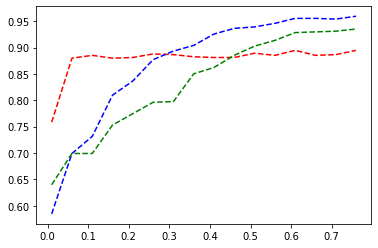

In [92]:
import matplotlib.pyplot as plt
# red dashes, blue squares and green triangles
plt.plot(ratio_range, hmm_results, 'r--', ratio_range, rnn_results, 'b--', ratio_range, lstm_results, 'g--')
plt.show()

# ***The experiment:***
The models of RNN, LSTM and HMM were trained on the partial datasets accroding to the ratio, in a for-loop manner iterating over different ratio values beggining on 0.01 to 0.8 with steps of 0.05.

# ***Results and conclusions:***
It can be seen from the plot, where the **red line** is **HMM**, the** blue line** is **RNN** and the **green line** is **LSTM**, that **the HMM is much more consistent with its result**, **it is better the the RNN and LSTM models till some point**, from which can be concluded that **for small amounts of data it performs better then the neural network models**, which is an expectable result, **because networks need as big as possible amounts of data to optimize efficiently their parameters**.** The RNN and LSTM models are pretty close in their accurancy**.** Generally the LSTM outperforms RNN** in cases were there is a lot data, here we can see mostly that RNN outperforms LSTM, which points on the small amount of data, and effect that also had been seen on the whole dataset. **The RNN outperforms both models, the lstm model on pretty early point of ratio\~0.06**, and **the HMM model about ratio\~2.6**, which points out as was mentioned that **with enough data it better then an HMM model, but as the amounts of data generally too small, it also outperforms LSTM**.
**The LSTM also outperform HMM as expected for a neural network model with more data then the RNN, about ratio\~4.6.**   

<!-- BEGIN QUESTION -->

## Debrief

**Question:** We're interested in any thoughts you have about this project segment so that we can improve it for later years, and to inform later segments for this year. Please list any issues that arose or comments you have to improve the project segment. Useful things to comment on include the following: 

* Was the project segment clear or unclear? Which portions?
* Were the readings appropriate background for the project segment? 
* Are there additions or changes you think would make the project segment better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

* It was very clear.  
* The reading and the previous labs were a good background for the assigment.
* Nothing comes to my mind.

<!-- END QUESTION -->



## Instructions for submission of the project segment

This project segment should be submitted to Gradescope, which will be made available some time before the due date.

Project segment notebooks are manually graded, not autograded using otter as labs are. (Otter is used within project segment notebooks to synchronize distribution and solution code however.) **We will not run your notebook before grading it.** Instead, we ask that you submit the already freshly run notebook. The best method is to "restart kernel and run all cells", allowing time for all cells to be run to completion.

We also request that you **submit a PDF of the freshly run notebook**. The simplest method is to use "Export notebook to PDF", which will render the notebook to PDF via LaTeX. If that doesn't work, the method that seems to be most reliable is to export the notebook as HTML (if you are using Jupyter Notebook, you can do so using `File -> Print Preview`), open the HTML in a browser, and print it to a file. Then make sure to add the file to your git commit. Please name the file the same name as this notebook, but with a `.pdf` extension. (Conveniently, the methods just described will use that name by default.) You can then perform a git commit and push and submit the commit to Gradescope.

# End of project segment 2